In [138]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer

import collections

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

## Importer la data dans un dataframe

In [139]:
# Import du dataframe "data.csv"
data = pd.read_csv('dataset_train_test.csv', delimiter=';')
df = data.copy()

In [140]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,NaN,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,NaN,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9562 entries, 0 to 9561
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    7636 non-null   object
 1   Metier        9562 non-null   object
 2   Technologies  9562 non-null   object
 3   Diplome       9562 non-null   object
 4   Experience    8531 non-null   object
 5   Ville         9562 non-null   object
dtypes: object(6)
memory usage: 448.3+ KB


In [142]:
df.describe()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
count,7636,9562,9562,9562,8531,9562
unique,1320,4,57,13,21,14
top,Ball Aerospace,Data scientist,SQL/R/Python//Big data,Master,"1,5",Paris
freq,598,3865,539,3314,908,2011


## Les valeurs manquantes 

In [143]:
df.isnull().sum()

Entreprise      1926
Metier             0
Technologies       0
Diplome            0
Experience      1031
Ville              0
dtype: int64

Number of misssing values for every feature

In [144]:
df.shape

(9562, 6)

The dataframe contains 9562 rows and 6 columns

In [145]:
df.dtypes.value_counts()

object    6
dtype: int64

All features have the same type: object

<AxesSubplot: >

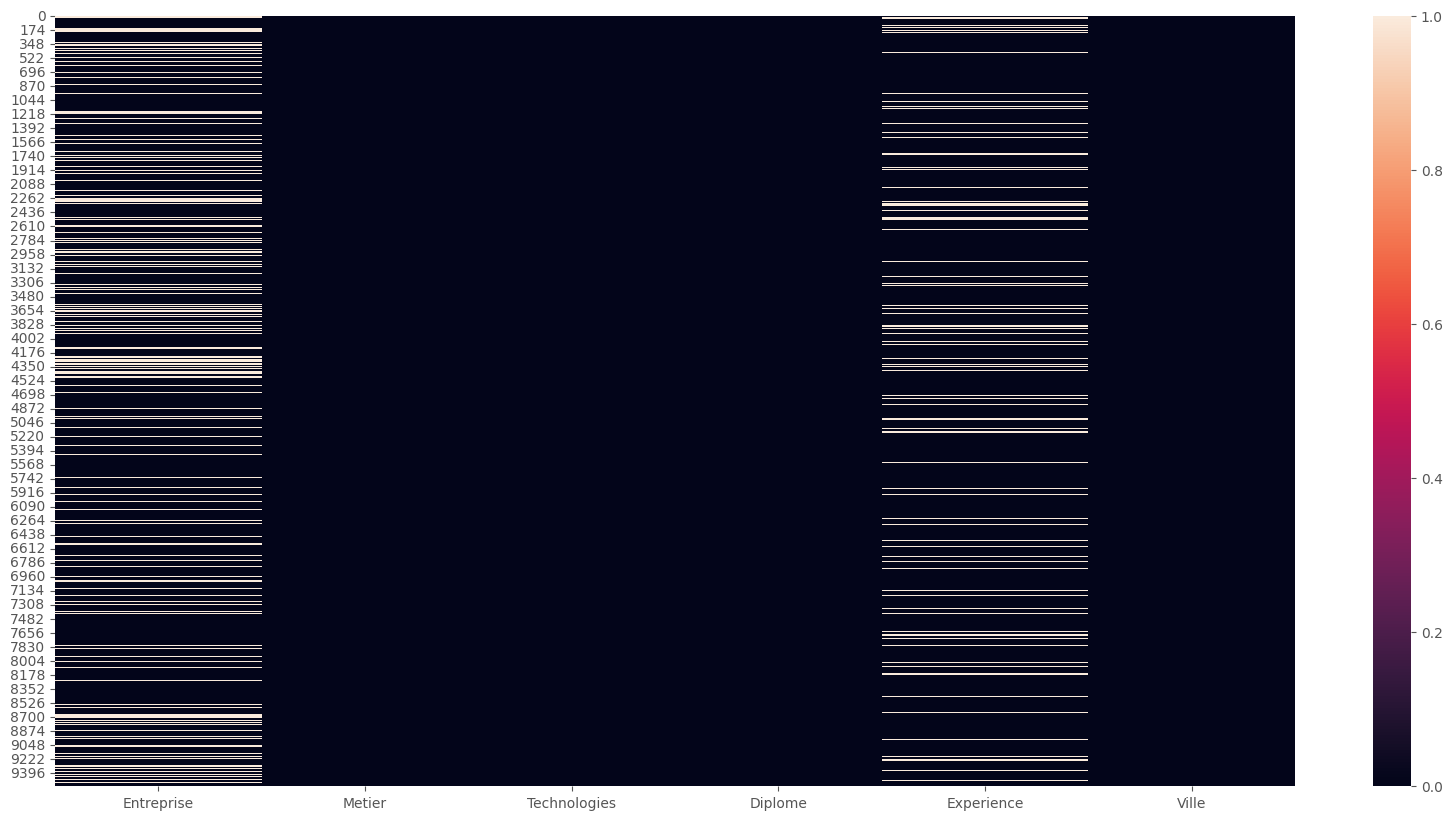

In [146]:
plt.figure(figsize=(20,10))
sb.heatmap(df.isnull())

The heatmap here is used to visualize missing values

In [147]:
(df.isna().sum()/df.shape[0]).sort_values()

Metier          0.000000
Technologies    0.000000
Diplome         0.000000
Ville           0.000000
Experience      0.107823
Entreprise      0.201422
dtype: float64

The percentage of missing values for every feature (column)

## Imputation des valeurs manquantes pour la variable Expérience

In [148]:
df['Metier'].value_counts()

Data scientist         3865
Data engineer          2347
Data architecte        2123
Lead data scientist    1227
Name: Metier, dtype: int64

In [149]:
df['Metier'].value_counts(normalize=True)

Data scientist         0.404204
Data engineer          0.245451
Data architecte        0.222025
Lead data scientist    0.128320
Name: Metier, dtype: float64

We have umbalanced data if we will use Metier as a target in the last question so we will use score F1, recall and precision as metrics

In [150]:
df.loc[df['Metier'] == 'Data scientist']

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,NaN,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0,Lille
7,Cedars-Sinai Medical Center,Data scientist,Java/C/C++/R/Python,BSc,4,Toulouse
...,...,...,...,...,...,...
9557,NaN,Data scientist,C++/R/Python/Matlab/Matplotlib,Master,"1,5",Lyon
9558,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,MSc,11,Toulouse
9559,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1,Paris
9560,NaN,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17,Rennes


To visualize data with data scientist as Metier

In [151]:
df[['Experience']].dtypes

Experience    object
dtype: object

In [152]:
df['Experience'] = [float(str(i).replace(",", ".")) for i in df['Experience']]
df['Experience']

0        1.0
1        3.0
2        3.0
3        1.5
4        NaN
        ... 
9557     1.5
9558    11.0
9559     1.0
9560    17.0
9561     0.0
Name: Experience, Length: 9562, dtype: float64

to convert Experience values to float so that we can process Imputation

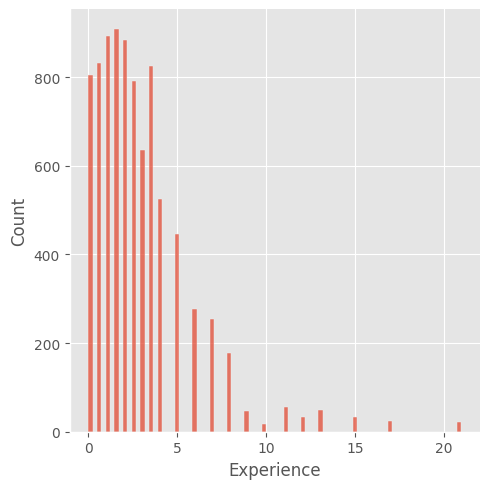

In [153]:
sb.displot(df['Experience'])

We notice that we have a right-skewed distribution: extreme values are far from the peak on the high end more frequently than on the low

In [154]:
for feature in df.select_dtypes('object'): 
    print(feature, df[feature].unique())

Entreprise ['Sanofi' 'Massachusetts General Hospital(MGH)' nan ... 'Galvanize'
 'Marsh' 'Ra Pharmaceutical']
Metier ['Data scientist' 'Data architecte' 'Lead data scientist' 'Data engineer']
Technologies ['Matlab/Python/Pyspark/Scikit-learn/Tensorflow'
 'Python/Java/Scala/MongoDB'
 'SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-learn' 'C/C++/Java/Python'
 'Matlab/Python/C++/numpy/Tensorflow/scikit-learn' 'VBA/Python/Excel/R'
 'Excel/VBA/R/Python/PySpark' 'Java/C/C++/R/Python' 'Java/Linux/Docker'
 'Python/Java/Linux/GNU' 'Hadoop/Hive/SQL/MariaDB'
 'Python/R/machine learning/Excel/VBA/C++' 'Python/Spark/Hive/Hadoop'
 'Python/AWS/Docker' 'Python/Tensorflow/scikit-learn/Deep learning/R'
 'Python/Pyspark/Spark' 'Docker/PostgreSQL/Elasticsearch/Kibana/MongoDB'
 'R/machine learning/Excel/VBA' 'Elasticsearch/Kibana/MongoDB'
 'Java/Hadoop/HDFS/Yarn' 'Python/Pyspark/machine learning/Microsoft Azure'
 'Elasticsearch/Kibana/Redshift'
 'SAS/Teradata/SQL/R/Python/Machine learning/Anglais'
 'Excel/Pyt

In [155]:
df['Entreprise'].value_counts()

Ball Aerospace                     598
Amazon.com                         105
KPMG                                95
Brigham & Women's Hospital(BWH)     94
McKinsey & Company                  88
                                  ... 
Getty Images                         1
Transfix.io                          1
Lockstep, Inc.                       1
Projectline                          1
Ra Pharmaceutical                    1
Name: Entreprise, Length: 1320, dtype: int64

In [156]:
df['Ville'].value_counts()

Paris          2011
Lyon           1775
Marseille      1544
Toulouse        869
Lille           771
Bordeaux        690
Nantes          365
Rennes          359
Rouen           315
Strasbourg      309
Toulon          186
Nice            183
Grenoble         98
Montpellier      87
Name: Ville, dtype: int64

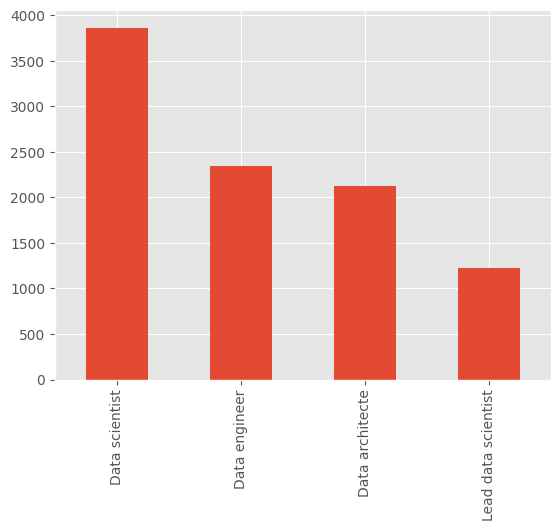

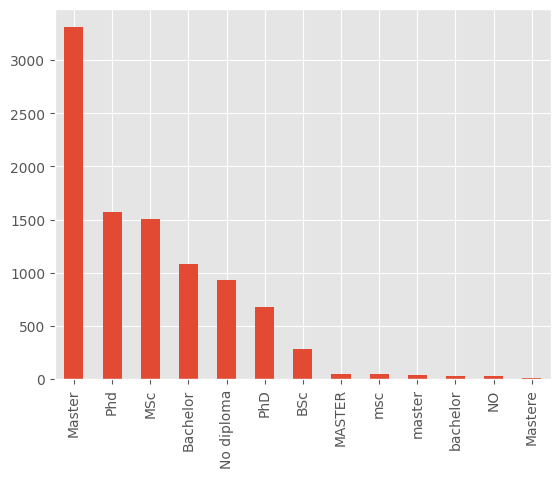

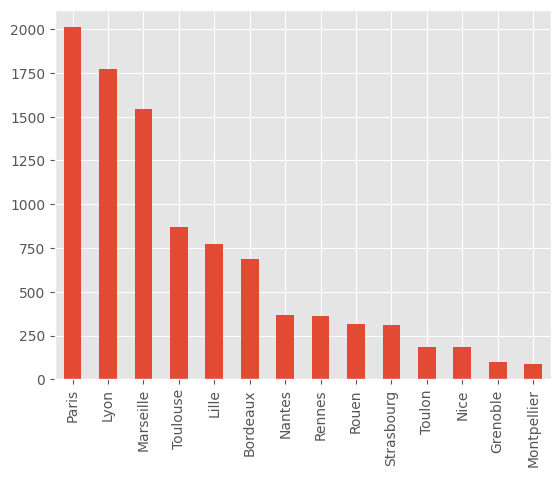

In [157]:
toPlot =['Metier', 'Diplome', 'Ville']
for feature in toPlot:
    plt.figure()
    df[feature].value_counts().plot.bar()

we notice that the feature Diplome 4 values indeed : PhD, master, bachelor and no diploma. However, the spelling of these words is different. So, we need to normalize this feature

In [158]:
df['Diplome'].unique()

array(['Master', 'Phd', 'Bachelor', 'BSc', 'MSc', 'No diploma', 'PhD',
       'MASTER', 'master', 'bachelor', 'NO', 'msc', 'Mastere'],
      dtype=object)

In [159]:
df['Diplome'].replace(['Master','MSc','MASTER','master','msc','Mastere'],'Master', inplace=True)

In [160]:
df['Diplome'].replace(['Bachelor','BSc','bachelor'],'Bachelor', inplace=True)

In [161]:
df['Diplome'].replace(['PhD','phd','Phd'],'PhD', inplace=True)

In [162]:
df['Diplome'].replace(['No diploma','NO'],'No diploma', inplace=True)

In [163]:
df['Diplome'].unique()

array(['Master', 'PhD', 'Bachelor', 'No diploma'], dtype=object)

<AxesSubplot: >

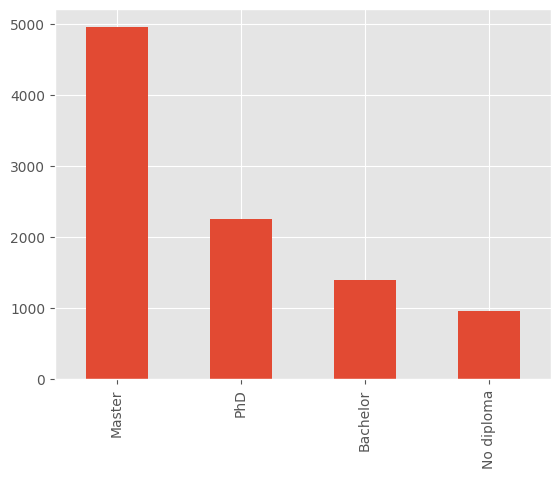

In [164]:
plt.figure()
df['Diplome'].value_counts().plot.bar()

<AxesSubplot: xlabel='Experience', ylabel='count'>

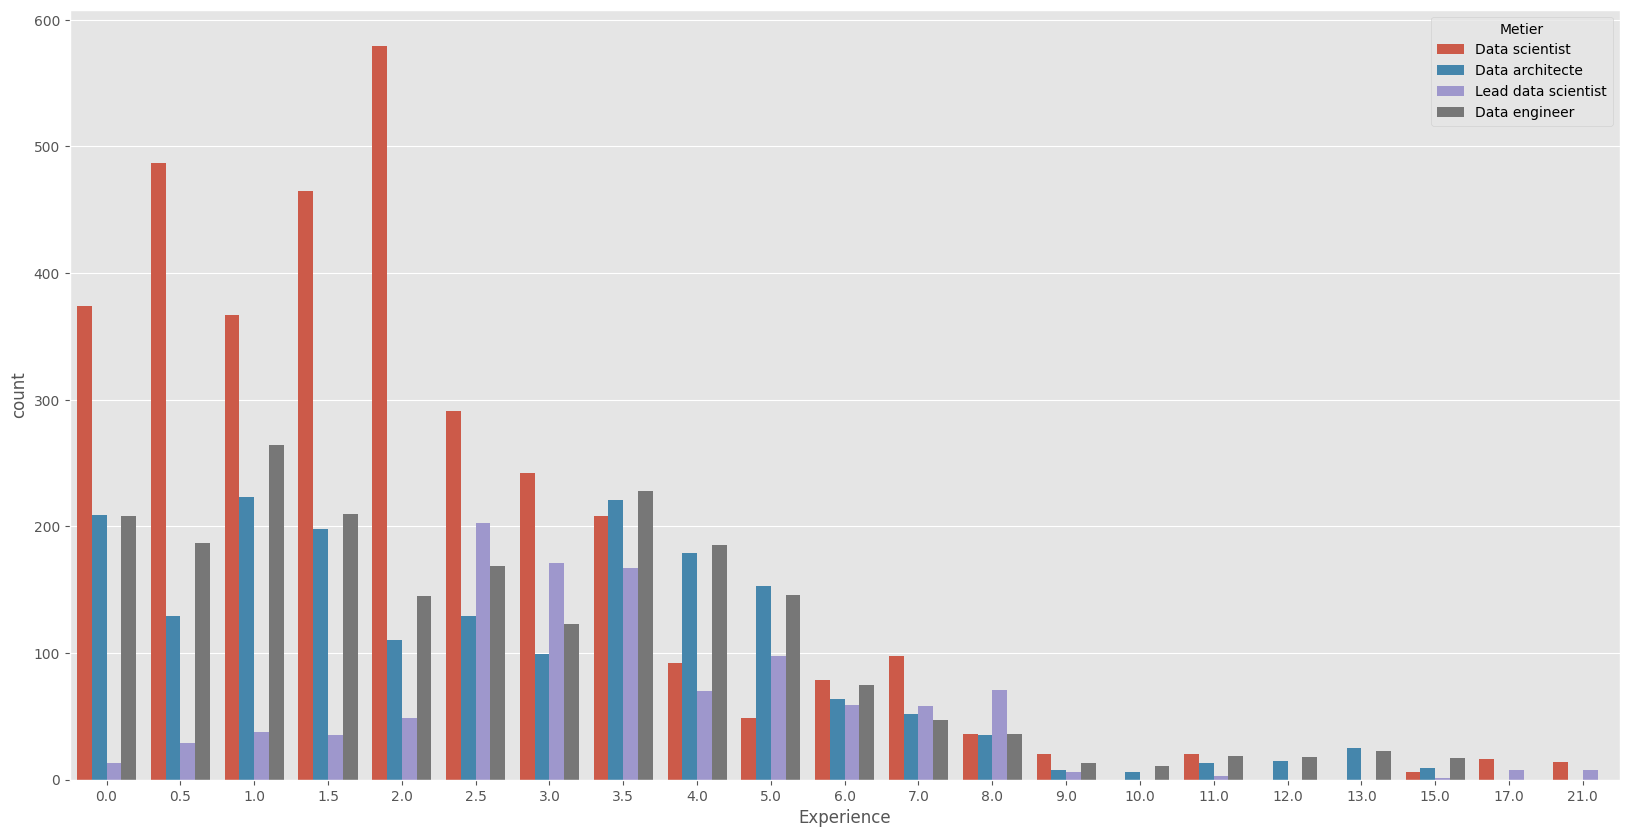

In [165]:
plt.figure(figsize=(20,10))
sb.countplot(x="Experience", hue="Metier", data = df)

This graph enables to visualize the relationship between the feature "Experience" and the target "Metier". Clearly, Experience is an important feature but we can't define its obvious impact on our target.

In [166]:
pd.crosstab(df['Metier'], df['Diplome'])

Diplome,Bachelor,Master,No diploma,PhD
Metier,,,,
Data architecte,426,1063,407,227
Data engineer,327,1276,445,299
Data scientist,438,1895,81,1451
Lead data scientist,200,727,24,276


This table enables to visualize the cross tabulation between our target "Metier" and the categorical feature "Diplome". It outputs the frequency table of these features

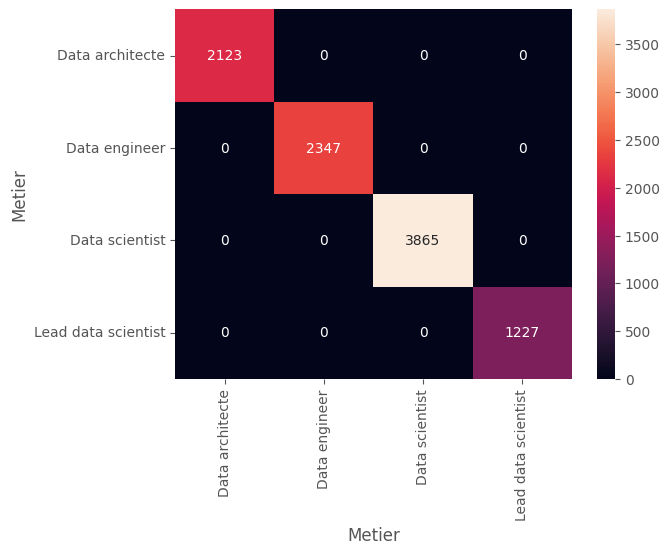

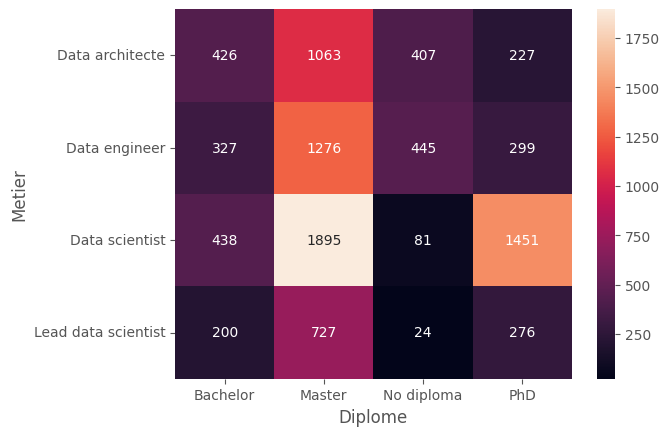

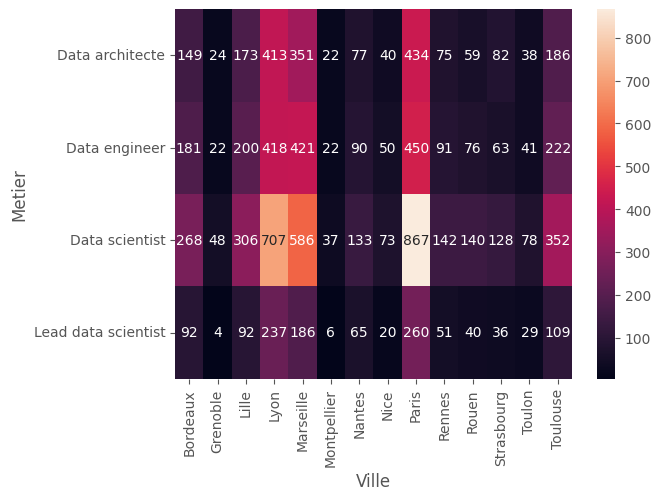

In [167]:
for feature in toPlot: 
    plt.figure()
    sb.heatmap(pd.crosstab(df['Metier'], df[feature]), annot=True, fmt='d' )

These heatmaps enable to visualize the cross tabulation between our target "Metier" and the categorical features "Diplome" and "Ville". They output the frequency table of these features

In [168]:
for job in df['Metier'].unique():
    print(job, df[df['Metier']==job]['Experience'].isnull().sum())

Data scientist 422
Data architecte 246
Lead data scientist 140
Data engineer 223


422 missing Experience values will be imputer for data scientists  
246 missing Experience values will be imputer for data architects  
140 missing Experience values will be imputer for Lead data scientists  
223 missing Experience values will be imputer for data engineers

## Pre-processing

In [169]:
imputerMedian = SimpleImputer(strategy='mean', missing_values=np.nan)
def imputationMedian(job):
    df.loc[df['Metier'] == job, 'Experience'] = imputerMedian.fit_transform(df.loc[df['Metier'] == job][['Experience']])
    return df


In [170]:
for job in df['Metier'].unique(): 
    imputationMedian(job)

Missing Experience values for all 'Metier' are replaced by the mean of other experience values

In [171]:
for job in df['Metier'].unique():
    print(job, df[df['Metier']==job]['Experience'].isnull().sum())

Data scientist 0
Data architecte 0
Lead data scientist 0
Data engineer 0


## Années d'expérience pour chaque profil

In [172]:
Profiles = ['Data scientist','Data engineer', 'Lead data scientist', 'Data architecte' ]
for profile in Profiles: 
    print(profile, df[df['Metier']==profile]['Experience'].mean())

Data scientist 2.255155387743247
Data engineer 2.963747645951036
Lead data scientist 3.96688132474701
Data architecte 2.9949387320191794


Text(0.5, 1.0, 'Comparison Study on years of experience of different Data related job positions')

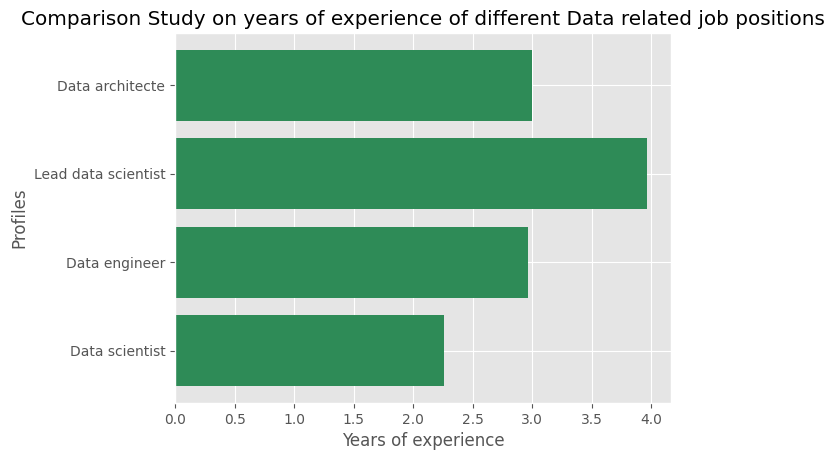

In [173]:
mean_scientist = df[df['Metier']=='Data scientist']['Experience'].mean()
mean_engineer = df[df['Metier']=='Data engineer']['Experience'].mean()
mean_lead = df[df['Metier']=='Lead data scientist']['Experience'].mean()
mean_architecte = df[df['Metier']=='Data architecte']['Experience'].mean()
mean_list = [mean_scientist, mean_engineer, mean_lead, mean_architecte]
plt.barh(Profiles,mean_list, color=["seagreen"])
plt.xlabel('Years of experience')
plt.ylabel('Profiles')
plt.title('Comparison Study on years of experience of different Data related job positions')

# Transformation de la variable continue 'Experience' en une nouvelle variable catégorielle à 4 modalités: débutant, confirmé, avancé et expert

In my implementation:  
debutant: has less than 2 years of experience   
Confirme: between 2 and 5 years of experience  
Avance: between 5 and 8 years of experience  
Expert: more than 8 years of experience

In [174]:
df['Exp_label'] = df['Experience'].apply(lambda x: 'debutant' if x<2 else ('Confirme' if x>=2 and x<5 else ('Avance' if x>=5 and x<8 else 'Expert' )))

In [175]:
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,Confirme
2,NaN,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,Confirme
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,debutant
4,NaN,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,PhD,2.255155,Bordeaux,Confirme
...,...,...,...,...,...,...,...
9557,NaN,Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.500000,Lyon,debutant
9558,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.000000,Toulouse,Expert
9559,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.000000,Paris,debutant
9560,NaN,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.000000,Rennes,Expert


# Visualisation des technologies les plus utilisées

In [176]:
df['Technologies'].describe()

count                       9562
unique                        57
top       SQL/R/Python//Big data
freq                         539
Name: Technologies, dtype: object

In [177]:
df_new = df.copy()

In [178]:
technos = df_new['Technologies'].str.split('/', expand=True)
technos

,0,1,2,3,4,5,6
0,Matlab,Python,Pyspark,Scikit-learn,Tensorflow,None,None
1,Python,Java,Scala,MongoDB,None,None,None
2,SPSS,SQL,Teradata,R,Python,Tensorflow,scikit-learn
3,C,C++,Java,Python,None,None,None
4,Matlab,Python,C++,numpy,Tensorflow,scikit-learn,None
...,...,...,...,...,...,...,...
9557,C++,R,Python,Matlab,Matplotlib,None,None
9558,Excel,Python,Matlab,R,machine learning,anglais,None
9559,R,machine learning,Excel,VBA,None,None,None
9560,Python,Pyspark,machine learning,Microsoft Azure,None,None,None


Every Data specialts is working with many technologies (separated by /), so in order to count them we need to split different components of the column Technologies

In [179]:
df_new[['technos1', 'technos2','technos3','technos4','technos5','technos6','technos7' ]] = df_new['Technologies'].str.split('/', expand=True)

In [180]:
df_new = df_new.drop(['Technologies'], axis=1)

In [181]:
technos.describe()

,0,1,2,3,4,5,6
count,9562,9562,9340,7945,4551,1836,814
unique,23,26,31,29,16,9,3
top,Python,Python,Python,R,Python,Machine learning,Anglais
freq,2359,1776,872,1279,923,455,455


In [182]:
technos_array = technos.stack().tolist()
len(technos_array)

43610

technos dataframe will be stored in a list; technos_array contains all the technologies used by all data profiles. 

In [183]:
sorted_technos = sorted (technos_array, key=technos_array.count, reverse =True)

sorted_technos contains all the technologies sorted by their number of occurrence 

In [184]:
output = []
for x in sorted_technos:
    if x not in output:
        output.append(x)
print(len(output))
output

61


['Python',
 'R',
 'SQL',
 'Java',
 'Hadoop',
 'Excel',
 'C++',
 'Spark',
 'Linux',
 'MongoDB',
 'VBA',
 'machine learning',
 'SAS',
 'Docker',
 'Matlab',
 'Hive',
 'Tensorflow',
 'Elasticsearch',
 'Big data',
 'C',
 'Kibana',
 'AWS',
 'GNU',
 'Teradata',
 '',
 'scikit-learn',
 'Machine learning',
 'Anglais',
 'Pyspark',
 'HDFS',
 'SPSS',
 'Microsoft Azure',
 'MariaDB',
 'Scikit-learn',
 'Scala',
 'Cassandra',
 'Matplotlib',
 'AI',
 'Scoring',
 'Vertica',
 'Tableau',
 'Kafka',
 'Pycharm',
 'NoSQL',
 'Deep learning',
 'PostgreSQL',
 'Yarn',
 'Map-Reduce',
 'PIG',
 'HBASE',
 'PySpark',
 'anglais',
 'numpy',
 'Redshift',
 'NoSQ',
 'Hadoop(HDFS)',
 'ORACLE',
 'MySQL',
 'Windows',
 'Perl',
 'Ruby']

Python, R, SQL, Java and Hadoop are the most used technologies by data specialists  
It is imporatant to highlight the fact that there are 61 different technologies used by the different profiles or exactly 60 since we have '' has a technology

Text(0, 0.5, 'Number of Occurence')

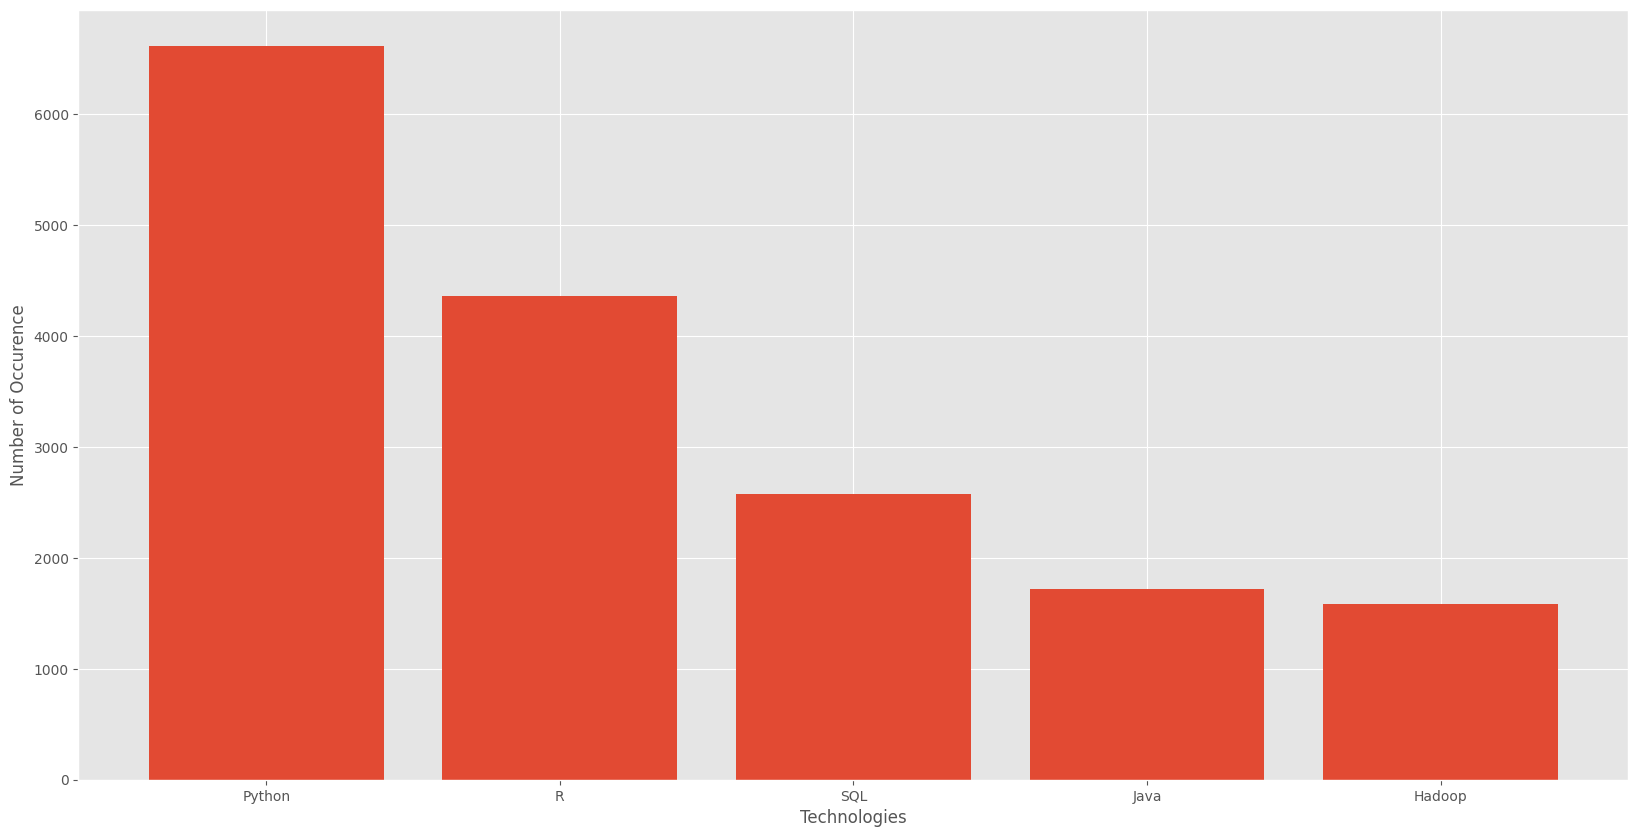

In [185]:
plt.figure(figsize=(20,10))

occurrences = collections.Counter(sorted_technos)
#print(type(occurrences))

technos_first_5 = [tech for tech, cnt in occurrences.most_common(5)]
cnt_first_5 = [cnt for tech, cnt in occurrences.most_common(5)]

plt.bar(technos_first_5, cnt_first_5)
plt.xlabel('Technologies')
plt.ylabel('Number of Occurence')

Python, R, SQL, Java and Hadoop are the most used technologies by data specialists

# Encodage

Encodage is an important preprocessing technique. We believe that manually encoding the features will enhance the performances of our classification techniques. For some classification models (such as KNN), it is important to transform categorical features into numerical ones. 

In [186]:
code_Metier = {'Data scientist': 0,
              'Data engineer': 1,
              'Data architecte': 2,
              'Lead data scientist': 3}
df_new['Metier'] = df_new['Metier'].map(code_Metier)

In [187]:
code_Diplome = {'No diploma': 0,
              'Bachelor': 1,
              'Master': 2,
              'PhD': 3}
df_new['Diplome'] = df_new['Diplome'].map(code_Diplome)

In [188]:
code_Exp = {'debutant': 0,
              'Confirme': 1,
              'Avance': 2,
              'Expert': 3}
df_new['Exp_label'] = df_new['Exp_label'].map(code_Exp)

In [189]:
code_Ville = {'Paris': 0,
              'Lyon': 1,
              'Marseille': 2,
              'Toulouse': 3,
             'Lille': 4,
              'Bordeaux': 5,
              'Nantes': 6,
              'Rennes': 7,
              'Rouen': 8,
              'Strasbourg': 9,
              'Toulon': 10,
              'Nice': 11,
              'Grenoble': 12,
              'Montpellier': 13            
             }
df_new['Ville'] = df_new['Ville'].map(code_Ville)

In [190]:
df_new = df_new.fillna(value= "No more")

In [191]:
code_technos = {'No more':0,
    'Python':1,
 'R':2,
 'SQL':3,
 'Java':4,
 'Hadoop':5,
 'Excel':6,
 'C++':7,
 'Spark':8,
 'Linux':9,
 'MongoDB':10,
 'VBA':11,
 'machine learning':12,
 'SAS':13,
 'Docker':14,
 'Matlab':15,
 'Hive':16,
 'Tensorflow':17,
 'Elasticsearch':18,
 'Big data':19,
 'C':20,
 'Kibana':21,
 'AWS':22,
 'GNU':23,
 'Teradata':24,
 'scikit-learn':25,
 'Machine learning':26,
 'Anglais':27,
 'Pyspark':28,
 'HDFS':29,
 'SPSS':30,
 'Microsoft Azure':31,
 'MariaDB':32,
 'Scikit-learn':33,
 'Scala':34,
 'Cassandra':35,
 'Matplotlib':36,
 'AI':37,
 'Scoring':38,
 'Vertica':39,
 'Tableau':40,
 'Pycharm':41,
 'Kafka':42,
 'NoSQL':43,
 'Deep learning':44,
 'PostgreSQL':45,
 'Yarn':46,
 'Map-Reduce':47,
 'PIG':48,
 'HBASE':49,
 'PySpark':50,
 'anglais':51,
 'numpy':52,
 'Redshift':53,
 'NoSQ':54,
 'Hadoop(HDFS)':55,
 'ORACLE':56,
 'MySQL':57,
 'Windows':58,
 'Perl':59,
 'Ruby':60,
  '': 61 }

technos_list = ['technos1', 'technos2', 'technos3', 'technos4', 'technos5', 'technos6', 'technos7']

for tech in technos_list:
    df_new[tech] = df_new[tech].map(code_technos)

In [192]:
df_new.drop(['Entreprise', 'Experience'], axis = 1, inplace = True) 

In [193]:
df_new

,Metier,Diplome,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6,technos7
0,0,2,0,0,15,1,28,33,17,0,0
1,2,2,2,1,1,4,34,10,0,0,0
2,3,2,6,1,30,3,24,2,1,17,25
3,0,2,2,0,20,7,4,1,0,0,0
4,0,3,5,1,15,1,7,52,17,25,0
...,...,...,...,...,...,...,...,...,...,...,...
9557,0,2,1,0,7,2,1,15,36,0,0
9558,0,2,3,3,6,1,15,2,12,51,0
9559,0,2,0,0,2,12,6,11,0,0,0
9560,0,2,7,3,1,28,12,31,0,0,0


# cross-validation strategy

To objective of this pre-processing technique is to split df_train_pred into two subsets to train and validate the different classification models.

In [194]:
X_df = df_new.drop('Metier', axis = 1)
y_df = df_new['Metier']

In [195]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size = 0.3)

# Classification model 1: KNeighborsClassifier

Neighbours based classification is a type of lazy learning as it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the k nearest neighbours of each point.
This algorithm is robust to noisy training data, and effective if training data is large.

In [196]:
model1 = KNeighborsClassifier()
model1.fit(X_train, y_train)
print('Test score  ', model1.score(X_val,y_val))

Test score   0.8692924363889857


In [197]:
k = np.arange(1,50)
train_score, val_score = validation_curve(model1, X_train, y_train, param_name='n_neighbors', param_range=k, cv=5 )

KeyboardInterrupt: 

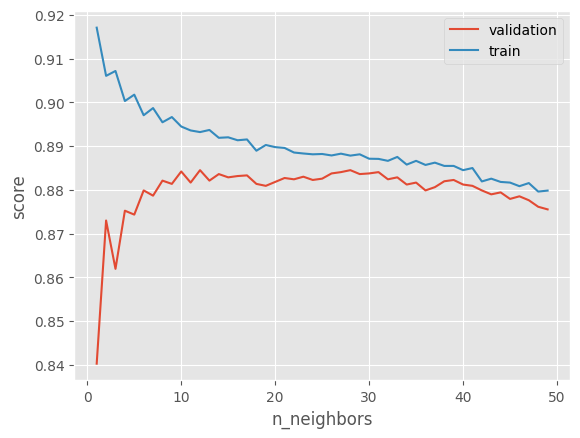

In [ ]:
plt.plot(k, val_score.mean(axis=1), label = 'validation')
plt.plot(k, train_score.mean(axis=1), label = 'train')

plt.ylabel ('score')
plt.xlabel('n_neighbors')
plt.legend()

This graph (training and validation curves) confirms that the optimal number of n_neighbors with the best accuracy is n_neighbors=28 for the KNeighborsClassifier method. However, we can also optimize other parameters. So, we will use the gridSearchCV. GridSearchCV enables to find the optimal hyperparameters for a classification model by comparing the different performances for every combinaison using the cross validation technique

In [ ]:
params_grid = {'n_neighbors': np.arange(1,50),
              'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), params_grid, cv=4)
grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [ ]:
grid.best_score_

0.88390915596004

The best model from this combinaison can have an accuracy of 88.30%

In [ ]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 23}

In [ ]:
model_grid = grid.best_estimator_

We build our classification model using the best hyperparameters from the results of applying GridSearchCV

In [ ]:
model_grid.score(X_val, y_val)

0.8745207389334263

When we run our model on the test set we obtain an accuracy of 87.45%

In [ ]:
confusion_matrix(y_val, model_grid.predict(X_val))

array([[1072,    0,    8,   78],
       [   0,  705,    0,    0],
       [  10,    0,  602,    0],
       [ 258,    0,    6,  130]], dtype=int64)

In [ ]:
print(classification_report(y_val, model_grid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1158
           1       1.00      1.00      1.00       705
           2       0.98      0.98      0.98       612
           3       0.62      0.33      0.43       394

    accuracy                           0.87      2869
   macro avg       0.85      0.81      0.82      2869
weighted avg       0.86      0.87      0.86      2869



In [ ]:
n, train_score_2, val_score_2  = learning_curve(model_grid, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 5)  , cv = 4)

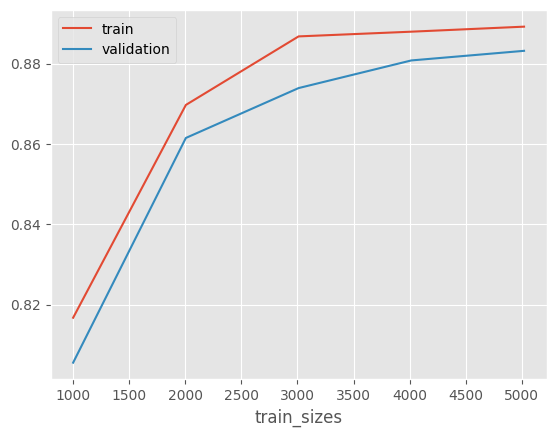

In [ ]:
plt.plot(n, train_score_2.mean(axis=1), label = 'train')
plt.plot(n, val_score_2.mean(axis=1), label = 'validation')
plt.xlabel('train_sizes')
plt.legend()

We notice that from value 4000 (train_size = 4000 values) the model does not evolve and it starts to stagnate. So, there is no need to require more data to enhance the performances of our model is this case (using KNeighborsClassifier()) 

# Classification model 2: Decision Tree

Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.
However, it can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.

In [ ]:
model_decTree = DecisionTreeClassifier(random_state=0)

In [ ]:
def evaluation(model): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    n_2, train_score_3, val_score_3 = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.2, 1.0, 5)  , cv = 4)
    
    plt.plot(n_2, train_score_3.mean(axis=1), label = 'train')
    plt.plot(n_2, val_score_3.mean(axis=1), label = 'validation')
    plt.xlabel('train_sizes')
    plt.legend()

[[1016    0   11  131]
 [   0  705    0    0]
 [  14    0  597    1]
 [ 234    0    2  158]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1158
           1       1.00      1.00      1.00       705
           2       0.98      0.98      0.98       612
           3       0.54      0.40      0.46       394

    accuracy                           0.86      2869
   macro avg       0.83      0.81      0.82      2869
weighted avg       0.85      0.86      0.86      2869



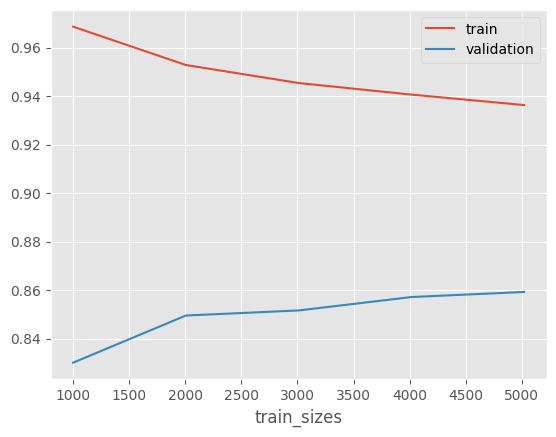

In [ ]:
evaluation(model_decTree)

an overfitting problem is observed from the learning curve figure. The model is able to perform much better on the train_set (accuracy>93%) than on the test_set (<88%). So, for the decision tree model, many configurations could be executed to avoid the overfitting: we can require more data since we abserve that the validation score increases with the train_size and the training_score decrease with the same parameter. Also, we can use another more sophisticated model: the RandomForestClassifier

# Classification model 3: Random Forest

Random forest classifier is a meta-estimator that fits a number of decision trees on various sub-samples of datasets and uses average to improve the predictive accuracy of the model and controls over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement.

[[1011    0   11  136]
 [   0  705    0    0]
 [  13    0  598    1]
 [ 218    0    2  174]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1158
           1       1.00      1.00      1.00       705
           2       0.98      0.98      0.98       612
           3       0.56      0.44      0.49       394

    accuracy                           0.87      2869
   macro avg       0.84      0.82      0.83      2869
weighted avg       0.86      0.87      0.86      2869



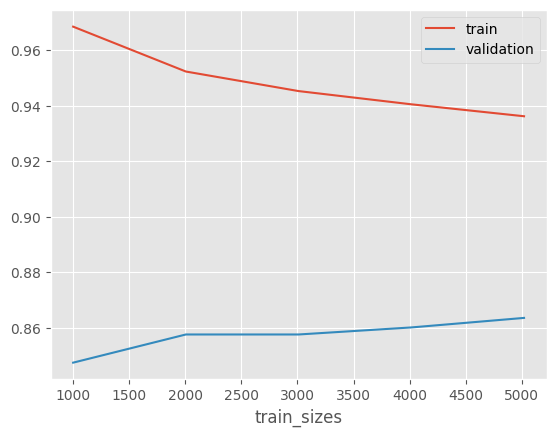

In [ ]:
model_RanForest = RandomForestClassifier(random_state=0)
evaluation(model_RanForest)

With a total accuracy of 0.87, we have a slightly better performance than the decision tree model but we still have the overfitting prolem. That's why, we will build an optimized random forest classifier model where we will use SelectKBest to select the most impactful features for the model

In [ ]:
modelRandomOptimized = make_pipeline(SelectKBest(f_classif, k = 4),    
                                    RandomForestClassifier(random_state=0)) # k =4 to choose the 4 best features that impact the model

[[1079    0   22   57]
 [   0  651   54    0]
 [   2   61  549    0]
 [ 287    0    6  101]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1158
           1       0.91      0.92      0.92       705
           2       0.87      0.90      0.88       612
           3       0.64      0.26      0.37       394

    accuracy                           0.83      2869
   macro avg       0.80      0.75      0.76      2869
weighted avg       0.82      0.83      0.81      2869



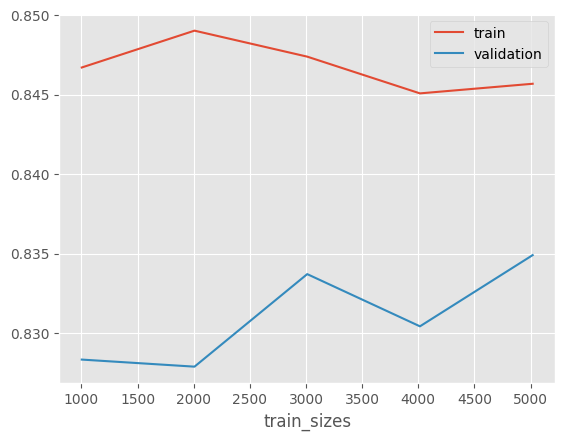

In [ ]:
evaluation(modelRandomOptimized)

Problem of overfitting not solved

# Classification model 4: AdaBoostClassifier

[[634 524   0   0]
 [ 56 567  82   0]
 [ 23 242 347   0]
 [249 145   0   0]]


c:\Users\WaelSAIDENI\anaconda3\envs\kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WaelSAIDENI\anaconda3\envs\kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WaelSAIDENI\anaconda3\envs\kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1158
           1       0.38      0.80      0.52       705
           2       0.81      0.57      0.67       612
           3       0.00      0.00      0.00       394

    accuracy                           0.54      2869
   macro avg       0.46      0.48      0.45      2869
weighted avg       0.53      0.54      0.51      2869



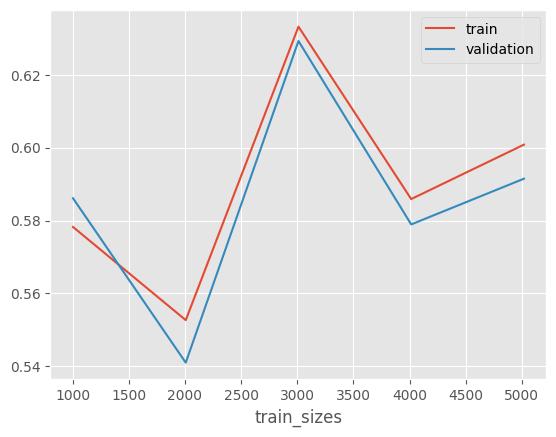

In [ ]:
modelAda = AdaBoostClassifier()
evaluation(modelAda)

From the confusion_matrix and the classification_report: the AdaBoostClassifier is the worst classification model among the aldready tested models. 

# Classification model 5: SVM

Support vector machine is a representation of the training data as points in space separated into categories by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.
It is effective in high dimensional spaces and uses a subset of training points in the decision function so it is also memory efficient.

Decision Tree, random forest and adaboost are all classifiers based on trees schemes so they do not require a normalization or standardization of the dataset. However, for SVM and KNN, we need to normalize data. So, we use StandardScaler to normalize data

[[1139    0    0   19]
 [   0  705    0    0]
 [  23    0  589    0]
 [ 335    0    0   59]]
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1158
           1       1.00      1.00      1.00       705
           2       1.00      0.96      0.98       612
           3       0.76      0.15      0.25       394

    accuracy                           0.87      2869
   macro avg       0.88      0.77      0.77      2869
weighted avg       0.87      0.87      0.84      2869



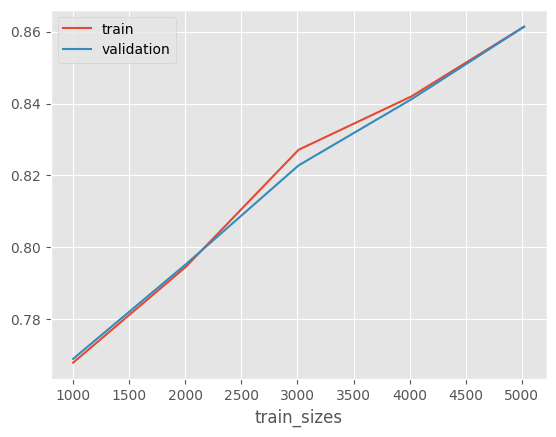

In [ ]:
#modelSVM = make_pipeline(StandardScaler(), SVC(random_state=0))
modelSVM = SVC(random_state=0)
evaluation(modelSVM)

In [ ]:
params_svm = {'C': [1, 10, 100, 1000], 'gamma': [1e-3,1e-4]}

grid_svm = GridSearchCV(modelSVM, params_svm, cv=4,verbose=2)
grid_svm.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ...................................C=1, gamma=0.001; total time=   0.8s
[CV] END ...................................C=1, gamma=0.001; total time=   0.8s
[CV] END ...................................C=1, gamma=0.001; total time=   0.8s
[CV] END ...................................C=1, gamma=0.001; total time=   0.8s
[CV] END ..................................C=1, gamma=0.0001; total time=   1.5s
[CV] END ..................................C=1, gamma=0.0001; total time=   1.7s
[CV] END ..................................C=1, gamma=0.0001; total time=   1.5s
[CV] END ..................................C=1, gamma=0.0001; total time=   1.9s
[CV] END ..................................C=10, gamma=0.001; total time=   0.8s
[CV] END ..................................C=10, gamma=0.001; total time=   0.7s
[CV] END ..................................C=10, gamma=0.001; total time=   0.9s
[CV] END ..................................C=10, 

GridSearchCV(cv=4, estimator=SVC(random_state=0),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
             verbose=2)

In [ ]:
grid_svm.best_params_

{'C': 1000, 'gamma': 0.001}

In [ ]:
y_pred_svm = grid_svm.predict (X_val)

In [ ]:
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1158
           1       1.00      1.00      1.00       705
           2       0.98      0.99      0.98       612
           3       0.66      0.25      0.36       394

    accuracy                           0.87      2869
   macro avg       0.86      0.80      0.80      2869
weighted avg       0.86      0.87      0.85      2869



[[1097    0   11   50]
 [   0  705    0    0]
 [   7    0  605    0]
 [ 291    0    4   99]]
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1158
           1       1.00      1.00      1.00       705
           2       0.98      0.99      0.98       612
           3       0.66      0.25      0.36       394

    accuracy                           0.87      2869
   macro avg       0.86      0.80      0.80      2869
weighted avg       0.86      0.87      0.85      2869



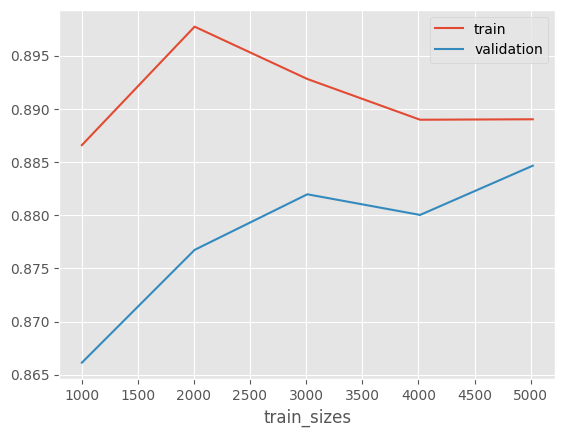

In [ ]:
evaluation(grid_svm.best_estimator_)

# Classification Results

We believe that the best classification models used in this use-case are KNN and SVM of course after using hyperparameters tunning techniques in order to find the optimal hyperparameters for the best performances.
We noticed that even we reached a classification score of 87%, we still have a problem with the prediction of class 3 which the "Lead data scientist class". The problem may come from the limited examples of "Lead data scientists" in the given dataset.
More data may solve the problem and enhance the performances of the classification models.

We will use KNN as a classification algorithm for the project. Then, we will generate a csv file with the predicted jobs in the test_raoul dataset. 

In [198]:
test_raoul = pd.read_csv('test_raoul.csv', delimiter=';')

In [199]:
test_raoul.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Symantec,NaN,Python/\nTensorflow/scikit-learn/deep learning/R,PhD,4.0,Marseille
1,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,NaN
2,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,NaN
3,eHire LLC,NaN,Java/C/C++/R/Python,Master,1.5,Toulouse
4,NaN,NaN,Map-Reduce/HDFS/PIG/HBASE/Python/Cassandra,Master,NaN,Bordeaux


In [200]:
df_test_raoul = test_raoul.copy()

In [201]:
df_test_raoul['Diplome'] = df_test_raoul['Diplome'].map(code_Diplome)

In [203]:
df_test_raoul['Exp_label'] = df_test_raoul['Experience'].apply(lambda x: 'debutant' if x<2 else ('Confirme' if x>=2 and x<5 else ('Avance' if x>=5 and x<8 else 'Expert' )))

In [205]:
technos_from_raoul = df_test_raoul['Technologies'].str.split('/', expand=True)

In [207]:
technos_from_raoul

,0,1,2,3,4,5
0,Python,\nTensorflow,scikit-learn,deep learning,R,None
1,Python,Spark,GNU,Linux,None,None
2,VBA,Python,Excel,R,None,None
3,Java,C,C++,R,Python,None
4,Map-Reduce,HDFS,PIG,HBASE,Python,Cassandra


In [208]:
df_test_raoul[['technos1', 'technos2','technos3','technos4','technos5','technos6' ]] = df_test_raoul['Technologies'].str.split('/', expand=True)

In [209]:
df_test_raoul = df_test_raoul.drop(['Technologies'], axis=1)

In [211]:
df_test_raoul['Exp_label'] = df_test_raoul['Exp_label'].map(code_Exp)

In [212]:
df_test_raoul['Ville'] = df_test_raoul['Ville'].map(code_Ville)

In [213]:
df_test_raoul

,Entreprise,Metier,Diplome,Experience,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6
0,Symantec,NaN,3,4.0,2.0,1,Python,\nTensorflow,scikit-learn,deep learning,R,None
1,Jacobs,NaN,0,2.5,NaN,1,Python,Spark,GNU,Linux,None,None
2,Ball Aerospace,NaN,2,15.0,NaN,3,VBA,Python,Excel,R,None,None
3,eHire LLC,NaN,2,1.5,3.0,0,Java,C,C++,R,Python,None
4,NaN,NaN,2,NaN,5.0,3,Map-Reduce,HDFS,PIG,HBASE,Python,Cassandra


In [216]:
df_test_raoul['Ville'] = df_test_raoul['Ville'].fillna(value= 0) #hypothèse = no value for Ville means Paris by default 

In [217]:
df_test_raoul

,Entreprise,Metier,Diplome,Experience,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6
0,Symantec,NaN,3,4.0,2.0,1,Python,\nTensorflow,scikit-learn,deep learning,R,None
1,Jacobs,NaN,0,2.5,0.0,1,Python,Spark,GNU,Linux,None,None
2,Ball Aerospace,NaN,2,15.0,0.0,3,VBA,Python,Excel,R,None,None
3,eHire LLC,NaN,2,1.5,3.0,0,Java,C,C++,R,Python,None
4,NaN,NaN,2,NaN,5.0,3,Map-Reduce,HDFS,PIG,HBASE,Python,Cassandra


In [218]:
df_test_raoul = df_test_raoul.fillna(value= "No more")

In [219]:
df_test_raoul

,Entreprise,Metier,Diplome,Experience,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6
0,Symantec,No more,3,4.0,2.0,1,Python,\nTensorflow,scikit-learn,deep learning,R,No more
1,Jacobs,No more,0,2.5,0.0,1,Python,Spark,GNU,Linux,No more,No more
2,Ball Aerospace,No more,2,15.0,0.0,3,VBA,Python,Excel,R,No more,No more
3,eHire LLC,No more,2,1.5,3.0,0,Java,C,C++,R,Python,No more
4,No more,No more,2,No more,5.0,3,Map-Reduce,HDFS,PIG,HBASE,Python,Cassandra


In [226]:
technos_list_from_raoul = ['technos1', 'technos2', 'technos3', 'technos4', 'technos5', 'technos6']

for tech in technos_list_from_raoul:
    df_test_raoul[tech] = df_test_raoul[tech].map(code_technos)

In [227]:
df_test_raoul

,Diplome,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6
0,3,2.0,1,1,NaN,25,NaN,2,0
1,0,0.0,1,1,8.0,23,9.0,0,0
2,2,0.0,3,11,1.0,6,2.0,0,0
3,2,3.0,0,4,20.0,7,2.0,1,0
4,2,5.0,3,47,29.0,48,49.0,1,35


In [222]:
df_test_raoul.drop(['Entreprise','Metier', 'Experience'], axis = 1, inplace = True) 

In [228]:
model_grid

KNeighborsClassifier(metric='euclidean', n_neighbors=23)

In [230]:
for tech in technos_list_from_raoul:
    df_test_raoul[tech] = df_test_raoul[tech].fillna(value= 0)

In [232]:
df_test_raoul['technos7'] = 0

In [233]:
final_submission_from_raoul = model_grid.predict(df_test_raoul)
final_submission_from_raoul

array([1, 1, 0, 0, 1], dtype=int64)

In [234]:
df_test_raoul['Metier'] = list(final_submission_from_raoul)

In [235]:
df_test_raoul

,Diplome,Ville,Exp_label,technos1,technos2,technos3,technos4,technos5,technos6,technos7,Metier
0,3,2.0,1,1,0.0,25,0.0,2,0,0,1
1,0,0.0,1,1,8.0,23,9.0,0,0,0,1
2,2,0.0,3,11,1.0,6,2.0,0,0,0,0
3,2,3.0,0,4,20.0,7,2.0,1,0,0,0
4,2,5.0,3,47,29.0,48,49.0,1,35,0,1


1 = data engineer  
0 = data scientist